In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from scipy.fftpack import fft, ifft

import sys
sys.path.append("../library/")
from defaultPlot import *
from readData import read, readPoints, extractRepeater
from stringFormat import *
from parameters import *

# Read Data

In [2]:
time = {}
trialTime = {}
points = {}
# ---------------------------------------------------------
ageDist_time = {}
clusterSizeDist = {}
clusterSizeDist_exact = {}
clusterSizeDist_time = {}
deltaUpperBoundDist_time = {}
interEventTime = {}
interEventTimeDist_time = {}
meanClusterSize = {}
meanClusterSize_trial = {}
orderParameter = {}
orderParameter_trial = {}
orderParameterDist = {}
orderParameterVariance = {}
orderParameterVariance_trial = {}

In [3]:
for networkSize in networkSizeList[:]:
# for networkSize in [1e4]:
    time[networkSize] = np.arange(0, 1, 1/networkSize)
    # for acceptanceThreshold in acceptanceThresholdList[:]:
    for acceptanceThreshold in [0.9]:
        current = networkSize, acceptanceThreshold
        points[current] = readPoints(networkSize, acceptanceThreshold)
# --------------------------------------------------------------------------------------------------------

        orderParameter[current] = read("orderParameter", networkSize, acceptanceThreshold)
        meanClusterSize[current] = read("meanClusterSize", networkSize, acceptanceThreshold)
        orderParameterVariance[current] = read("orderParameterVariance", networkSize, acceptanceThreshold)
        interEventTime[current] = read("interEventTime", networkSize, acceptanceThreshold)
        
# --------------------------------------------------------------------------------------------------------      
 
        # for state in ["before", "during", "after"]:
        #     ageDist_time[current, state] = read("ageDist_time/" + state, networkSize, acceptanceThreshold)
        #     interEventTimeDist_time[current, state] = read("interEventTimeDist_time/" + state, networkSize, acceptanceThreshold)
        #     deltaUpperBoundDist_time[current, state] = read("deltaUpperBoundDist_time/" + state, networkSize, acceptanceThreshold)

# --------------------------------------------------------------------------------------------------------       
 
        for op in extractRepeater("clusterSizeDist", networkSize, acceptanceThreshold):
            clusterSizeDist[current, op] = read("clusterSizeDist", networkSize, acceptanceThreshold, op)
        # for t in extractRepeater("orderParameterDist", networkSize, acceptanceThreshold):
            # orderParameterDist[current, t] = read("orderParameterDist", networkSize, acceptanceThreshold, t)

        # for op in extractRepeater("clusterSizeDist_exact", networkSize, acceptanceThreshold):
        #     clusterSizeDist_exact[current, op] = read("clusterSizeDist_exact", networkSize, acceptanceThreshold, op)
        # for t in extractRepeater("clusterSizeDist_time", networkSize, acceptanceThreshold):
        #     clusterSizeDist_time[current, t] = read("clusterSizeDist_time", networkSize, acceptanceThreshold, t)

# --------------------------------------------------------------------------------------------------------        
        # trialTime[current] = np.arange(0, len(orderParameter[current])/networkSize, 1/networkSize)
        # orderParameter_trial[current] = read("orderParameter_trial", networkSize, acceptanceThreshold)
        # meanClusterSize_trial[current] = read("meanClusterSize_trial", networkSize, acceptanceThreshold)
        # orderParameterVariance_trial[current] = read("orderParameterVariance_trial", networkSize, acceptanceThreshold)

# Plot zoomed order parameter and maximum slope

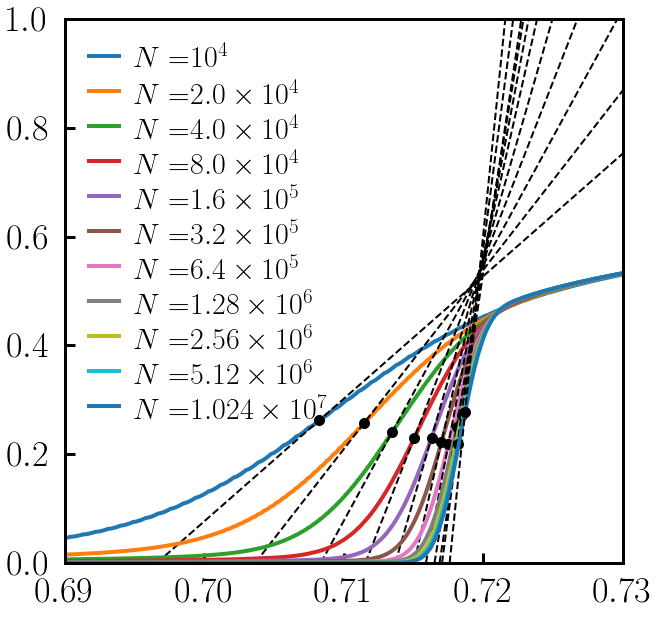

In [4]:
_, ax = plt.subplots(figsize = (10,10))

acceptanceThreshold = 0.9
plotRange = chi_plotRange[acceptanceThreshold]

for networkSize in networkSizeList[:]:
    current = networkSize, acceptanceThreshold
    start = int(plotRange[0] * networkSize); end = int(plotRange[1] * networkSize)
    op = orderParameter[current][start:end]; t = time[networkSize][start:end]
    t_inflection = points[current]["t_inflection"]; m_inflection = points[current]["m_inflection"]; t_a = points[current]["t_a"]

    ax.plot(t, op, label = latexString("N=") + latexSci(networkSize))
    ax.plot(t_inflection, m_inflection, 'ko', markersize = 10)
    ax.plot([t_a, t_a+(t_inflection - t_a)/m_inflection], [0, 1], 'k--', linewidth = 2)

ax.set_xlim(plotRange)
ax.set_ylim([0,1])
ax.legend(loc = "upper left", fontsize = 30)

plt.show()

# Plot Variance of order parameter

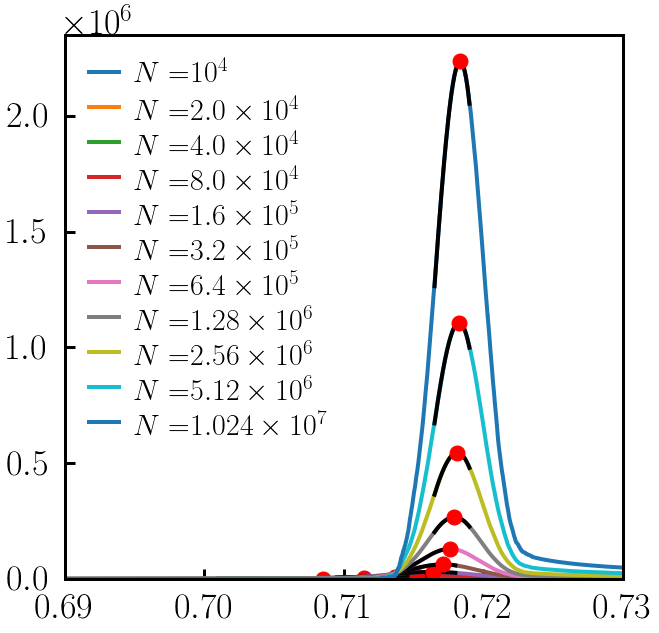

In [7]:
_, ax = plt.subplots(figsize = (10,10))

acceptanceThreshold = 0.9
plotRange = chi_plotRange[acceptanceThreshold]

for networkSize in networkSizeList[:]:
    current = networkSize, acceptanceThreshold
    fitRange = chi_fitRange[current]
    plotIndex = int(plotRange[0] * networkSize),int(plotRange[1] * networkSize); fitIndex = int(fitRange[0] * networkSize), int(fitRange[1] * networkSize)
    opv = orderParameterVariance[current]; t = time[networkSize]
    
    fit_poly = np.poly1d(np.polyfit(t[fitIndex[0]:fitIndex[1]], opv[fitIndex[0]:fitIndex[1]], 3))
    max_index = np.argmax(fit_poly(t[fitIndex[0]:fitIndex[1]]))
    t_c = t[fitIndex[0]+max_index]; m_c = orderParameter[current][fitIndex[0]+max_index]

    ax.plot(t[plotIndex[0]:plotIndex[1]], opv[plotIndex[0]:plotIndex[1]], label = latexString("N=") + latexSci(networkSize))
    ax.plot(t[fitIndex[0]:fitIndex[1]], fit_poly(t[fitIndex[0]:fitIndex[1]]), 'k-')
    ax.plot(t_c, fit_poly(t_c), 'ro')

    # with open("../data/mBFW_hybrid/points/" + "N{:.1e},G{:.1f}".format(networkSize, acceptanceThreshold) + ".txt", 'a') as file:
    #     file.write("t_c_var: " + str(t_c) + "\n")
    #     file.write("m_c_var: " + str(m_c) + "\n")

ax.set_xlim(plotRange)
ax.set_ylim(bottom = 0)
ax.legend(loc = "upper left", fontsize = 30)

plt.show()


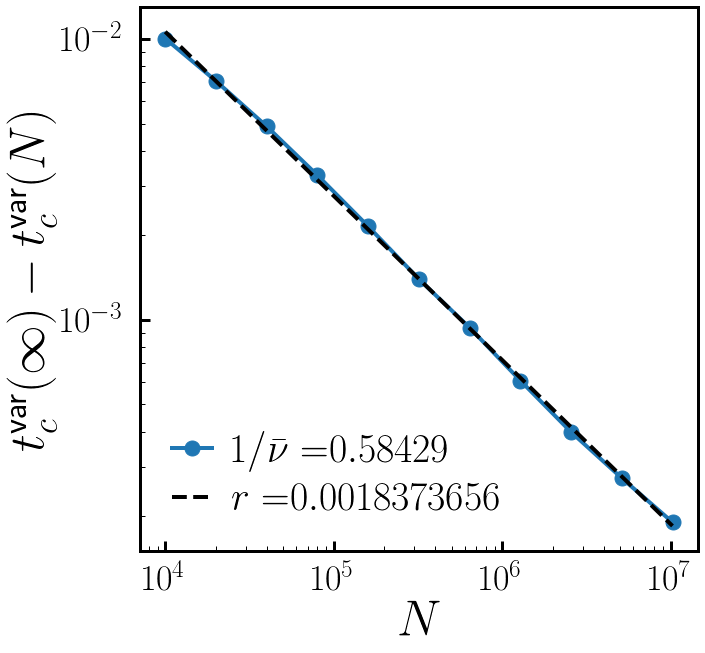

In [20]:
_, ax = plt.subplots(figsize = (10,10))

acceptanceThreshold = 0.9
x = networkSizeList[:]
y = []
for networkSize in x:
    point = readPoints(networkSize, acceptanceThreshold)
    y.append(0.718534 - point["t_c_var"])
    # y.append(t_c_var_inf[acceptanceThreshold] - point["t_c_var"])

fitX, fitY, nu, residual = logFit(x,y, offset=0)
ax.plot(x,y ,'o-', label=latexString("1/\\bar{\\nu}=") + latexFloat(-1*nu, 5))
ax.plot(fitX, fitY, 'k--', label=latexString("r=") + latexFloat(residual[0],10))

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("N")); ax.set_ylabel(latexString("t_c^\\text{var}(\infty) - t_c^\\text{var}(N)"))
ax.legend(loc="lower left")

plt.show()

# Plot mean cluster size

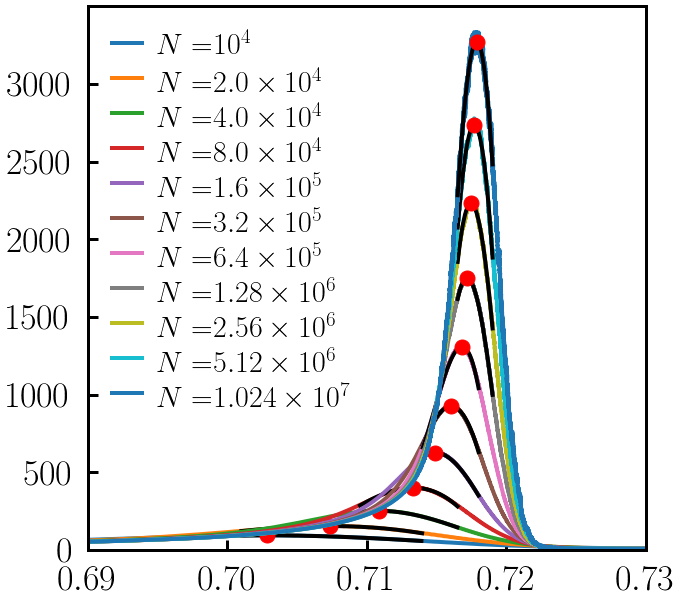

In [23]:
_, ax = plt.subplots(figsize = (10,10))

acceptanceThreshold = 0.9
plotRange = chi_plotRange[acceptanceThreshold]

for networkSize in networkSizeList[:]:
    current = networkSize, acceptanceThreshold 
    fitRange = chi_fitRange[networkSize, acceptanceThreshold]
    plotIndex = int(plotRange[0] * networkSize),int(plotRange[1] * networkSize)
    fitIndex = int(fitRange[0] * networkSize), int(fitRange[1] * networkSize)
    mcs = meanClusterSize[current]; t = time[networkSize]

    fit_poly = np.poly1d(np.polyfit(t[fitIndex[0]:fitIndex[1]], mcs[fitIndex[0]:fitIndex[1]], 3))
    max_index = np.argmax(fit_poly(t[fitIndex[0]:fitIndex[1]]))
    t_c = t[fitIndex[0]+max_index]; m_c = orderParameter[current][fitIndex[0]+max_index]

    ax.plot(t[plotIndex[0]:plotIndex[1]], mcs[plotIndex[0]:plotIndex[1]], label = latexString("N=") + latexSci(networkSize))
    ax.plot(t[fitIndex[0]:fitIndex[1]], fit_poly(t[fitIndex[0]:fitIndex[1]]), 'k-')
    ax.plot(t_c, fit_poly(t_c), 'ro')

    # with open("../data/mBFW_hybrid/points/" + "N{:.1e},G{:.1f}".format(networkSize, acceptanceThreshold) + ".txt", 'a') as file:
    #     file.write("t_c_mcs: " + str(t_c) + "\n")
    #     file.write("m_c_mcs: " + str(m_c) + "\n")

ax.set_xlim(plotRange)
ax.set_ylim(bottom = 0)
ax.legend(loc = "upper left", fontsize = 30)


plt.show()


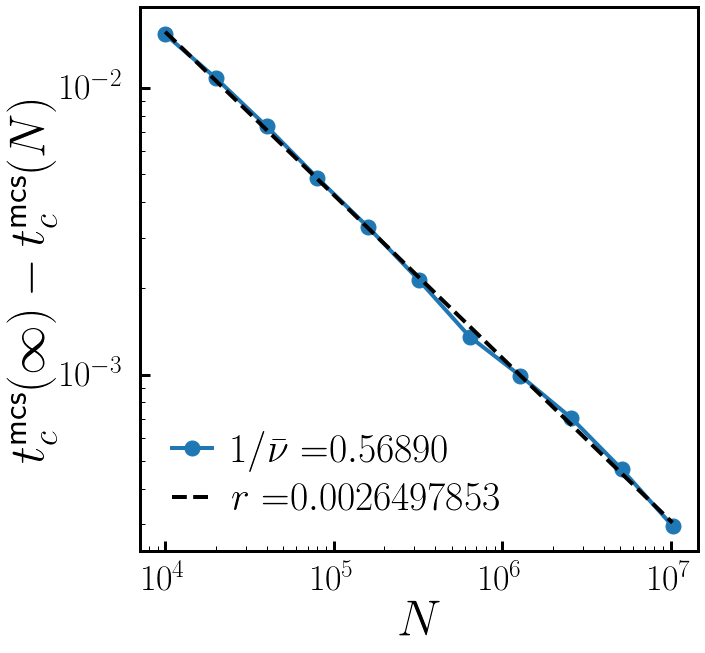

In [41]:
_, ax = plt.subplots(figsize = (10,10))

acceptanceThreshold = 0.9

x = networkSizeList[:]
y = []
for networkSize in x:
    point = readPoints(networkSize, acceptanceThreshold)
    y.append(0.718161 - point["t_c_mcs"])
    # y.append(t_c_mcs_inf[acceptanceThreshold] - point["t_c_mcs"])

fitX, fitY, nu, residual = logFit(x,y, offset=0)
ax.plot(x,y ,'o-', label=r"$1/\bar{\nu}=$" + latexFloat(-1*nu, 5))
ax.plot(fitX, fitY, 'k--', label=r"$r=$" + latexFloat(residual[0],10))

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("N")); ax.set_ylabel(latexString("t_c^\\text{mcs}(\infty) - t_c^\\text{mcs}(N)"))
ax.legend(loc='lower left')

plt.show()

# Finit Size Scaling

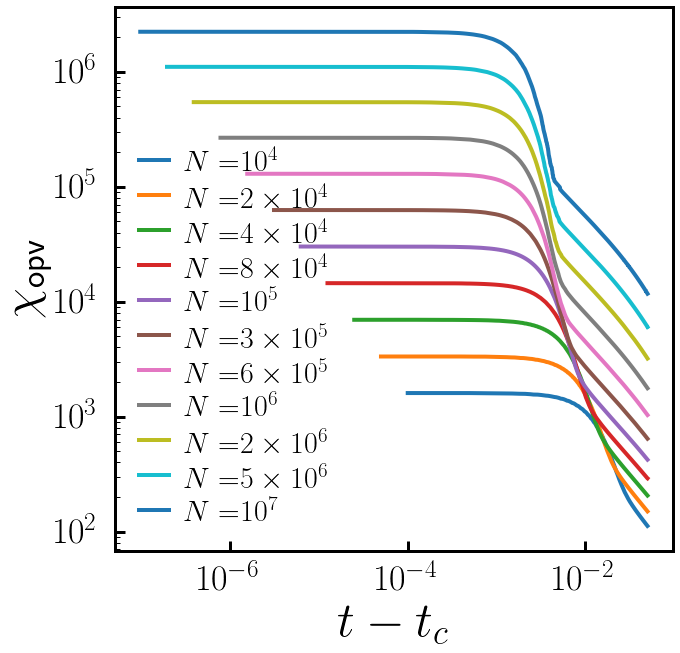

In [72]:
_, ax = plt.subplots(figsize = (10,10))
acceptanceThreshold = 0.9

t_c = t_c_var_inf[acceptanceThreshold]
for networkSize in networkSizeList[:]:
    t_c = t_c_var[networkSize, acceptanceThreshold]
    opv = orderParameterVariance[networkSize, acceptanceThreshold]
    t = time[networkSize]
    startIndex = int(t_c*networkSize)+1
    endIndex = int((t_c+5e-2)*networkSize)
    ax.plot(t[startIndex:endIndex]-t_c, opv[startIndex:endIndex], label = latexString("N=") + latexSci(networkSize))


ax.legend(loc = "lower left", fontsize = 30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$t-t_c$")
ax.set_ylabel(r"$\chi_\text{opv}$")

plt.show()


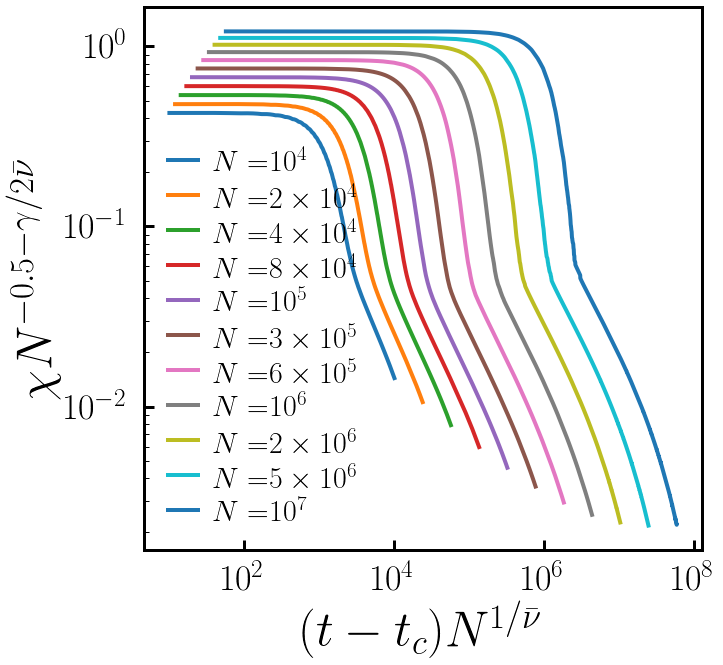

In [79]:
_, ax = plt.subplots(figsize = (10,10))
acceptanceThreshold = 0.9

t_c = t_c_var_inf[acceptanceThreshold]
for networkSize in networkSizeList[:]:
    t_c = t_c_var[networkSize, acceptanceThreshold]
    opv = orderParameterVariance[networkSize, acceptanceThreshold] 
    t = time[networkSize] 
    startIndex = int(t_c*networkSize)+1
    endIndex = int((t_c+1e-1)*networkSize)
    nu_bar = nu_bar_var[acceptanceThreshold]
    gamma = 0.63
    nu_bar = 0.8
    ax.plot((t[startIndex:endIndex]-t_c)* np.power(networkSize, 1/nu_bar), opv[startIndex:endIndex]* np.power(networkSize, -0.5-gamma/(2*nu_bar)), label = latexString("N=") + latexSci(networkSize))


ax.legend(loc = "lower left", fontsize = 30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$(t-t_c)N^{1/\bar{\nu}}$")
ax.set_ylabel(r"$\chi N^{-0.5-\gamma/2\bar{\nu}}$")

plt.show()


# Cluster Size Distribution

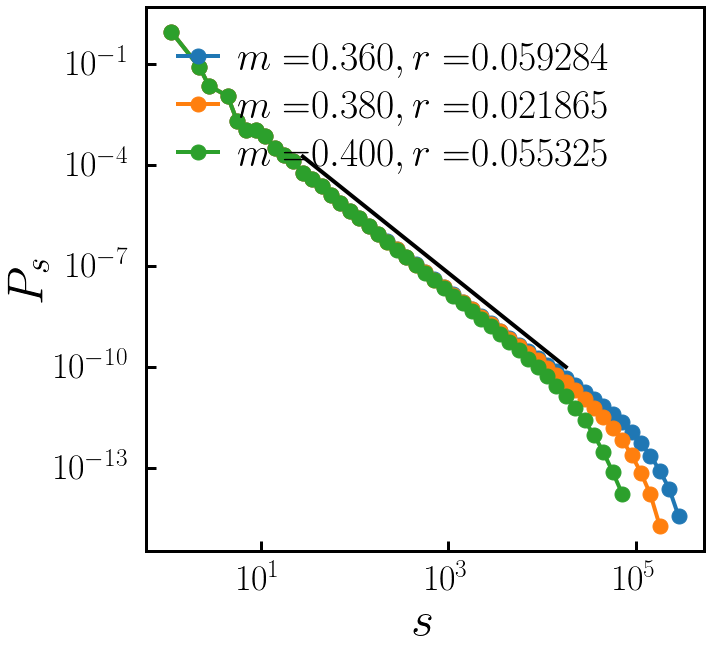

In [64]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 10240000; acceptanceThreshold = 0.9
current = networkSize, acceptanceThreshold
# fitRange = csd_fitRange[current]
fitRange = [11, 40]

def plotCSD(op, fit = False):
    csd, dist = clusterSizeDist[current, op]
    fitX, fitY, tau, residual = logFit(csd[fitRange[0] : fitRange[1]], dist[fitRange[0] : fitRange[1]], offset=-0.5)
    ax.plot(csd[:-1], dist[:-1], 'o-', label=latexString("m=") + latexFloat(op,3) + latexString(", r=") + latexFloat(residual[0], 6))
    if fit:
        ax.plot(fitX, fitY, 'k-')

# op = 0.25; plotCSD(op)
# op = 0.30; plotCSD(op)
op = 0.36; plotCSD(op)
op = 0.38; plotCSD(op, fit=True)
op = 0.40; plotCSD(op)

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("s")); ax.set_ylabel(latexString("P_s"))
ax.legend(loc='upper left')

plt.show()

# Age Distribution

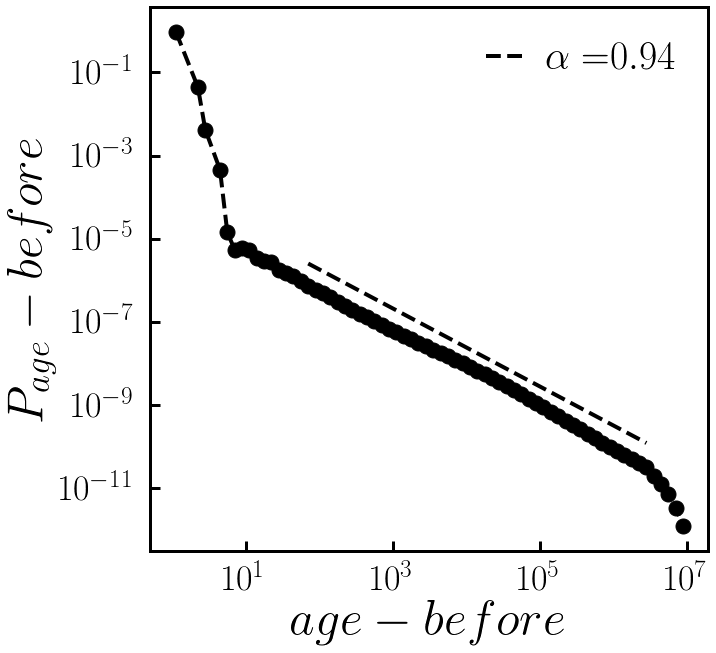

In [110]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 10240000; acceptanceThreshold = 0.4
current = networkSize, acceptanceThreshold

# main plot
age, dist = ageDist_time[current, "before"]
ax.plot(age, dist, 'ko--')
# log fit
fitX, fitY, alpha, residual = logFit(age[15:-5], dist[15:-5], offset=-0.5)
ax.plot(fitX, fitY, 'k--', label=latexString("\\alpha=") + latexFloat(-1 * alpha ,2))

# main setting
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("age-before")); ax.set_ylabel(latexString("P_{age}-before"))
ax.legend(loc='upper right')

# save and show
plt.show()

# Inter Event Time Dist

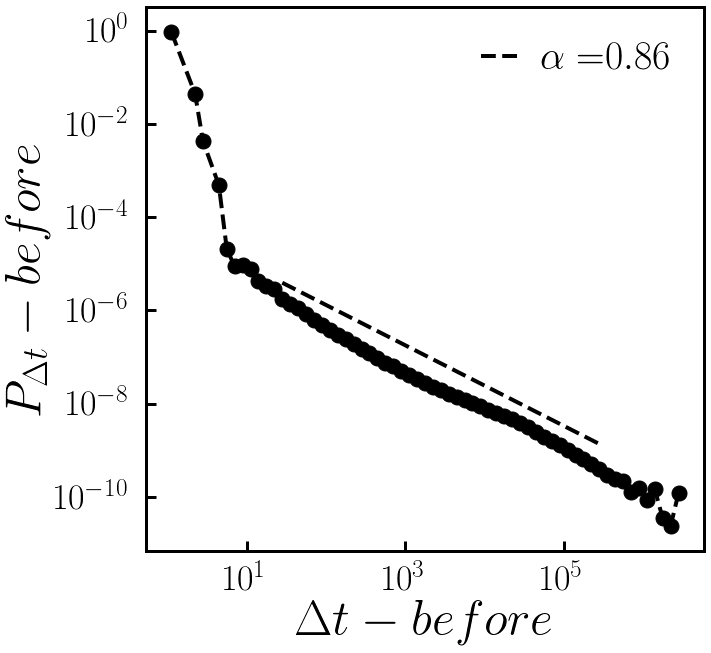

In [114]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 10240000; acceptanceThreshold = 0.4
current = networkSize, acceptanceThreshold

# main plot
iet, dist = interEventTimeDist_time[current, "before"]
ax.plot(iet, dist, 'ko--')

# log fit
fitX, fitY, alpha, residual = logFit(iet[11:-10], dist[11:-10], offset=-0.5)
ax.plot(fitX, fitY, 'k--', label=latexString("\\alpha=") + latexFloat(-1*alpha, 2))

# main setting
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("\\Delta t-before")); ax.set_ylabel(latexString("P_{\\Delta t}-before"))
ax.legend(loc='upper right')
# save and show
plt.show()



# Delta Upper bound Dist

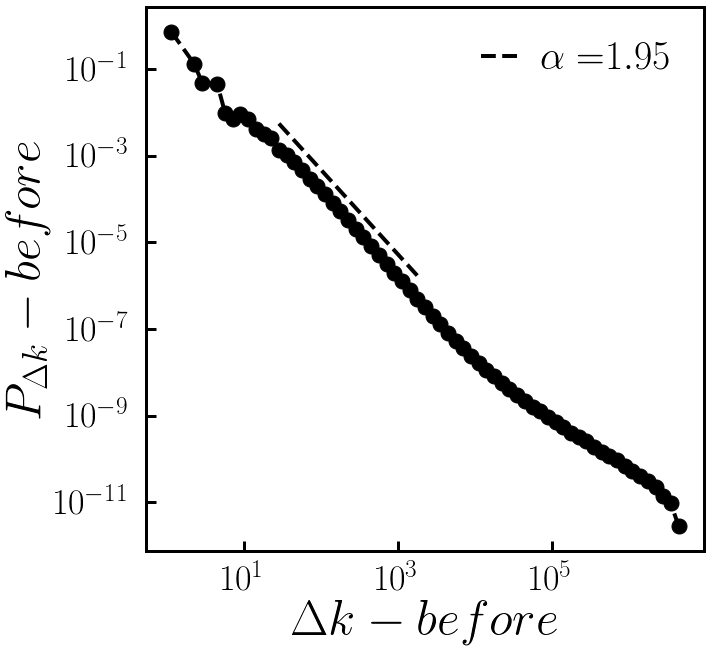

In [120]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 10240000; acceptanceThreshold = 0.4
current = networkSize, acceptanceThreshold

dk, dist = deltaUpperBoundDist_time[current, "during"]
ax.plot(dk, dist, 'ko--')

fitX, fitY, alpha, residual = logFit(dk[11:30], dist[11:30], offset=-0.5)
ax.plot(fitX, fitY, 'k--', label=latexString("\\alpha=") + latexFloat(-1*alpha,2))

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(latexString("\\Delta k-before")); ax.set_ylabel(latexString("P_{\\Delta k}-before"))
ax.legend(loc='upper right')

plt.show()

# Order Parameter Dist

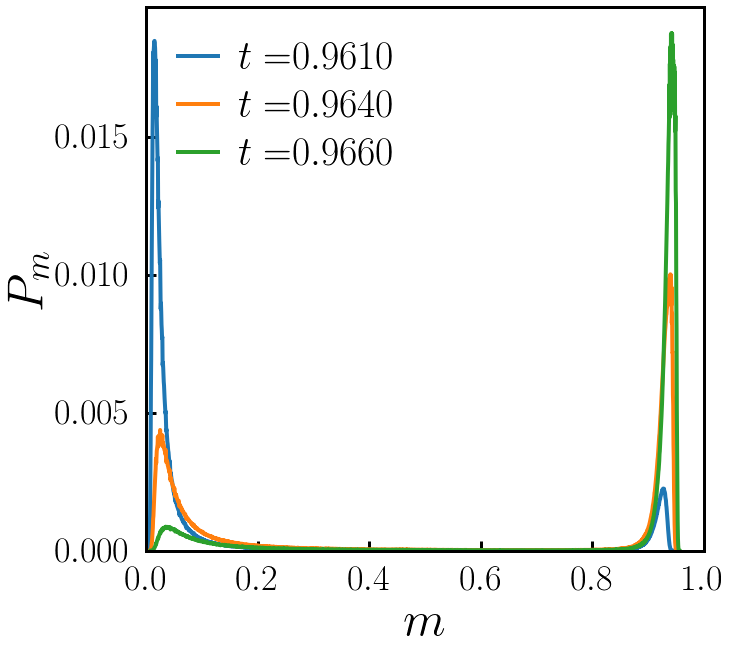

In [123]:
_, ax = plt.subplots()

networkSize = 40000; acceptanceThreshold = 0.4
current = networkSize, acceptanceThreshold

def plotOPD(t):
    op, dist = orderParameterDist[current, t]
    ax.plot(op, dist, label=latexString("t=") + latexFloat(t,4))

t=0.961; plotOPD(t)
t=0.964; plotOPD(t)
t=0.966; plotOPD(t)

# default setting
ax.legend(loc="upper left")
ax.set_xlabel(latexString("m")); ax.set_ylabel(latexString("P_m"))
ax.set_xlim([0.0, 1.0]); ax.set_ylim(bottom=0)
xtick = np.linspace(0.0, 1.0, 6); ax.set_xticks(xtick); ax.set_xticklabels(list_latexFloat(xtick,1))

# save and show
plt.show()

In [45]:
print(orderParameterDist)

{}


# -----------------------------------------------------------

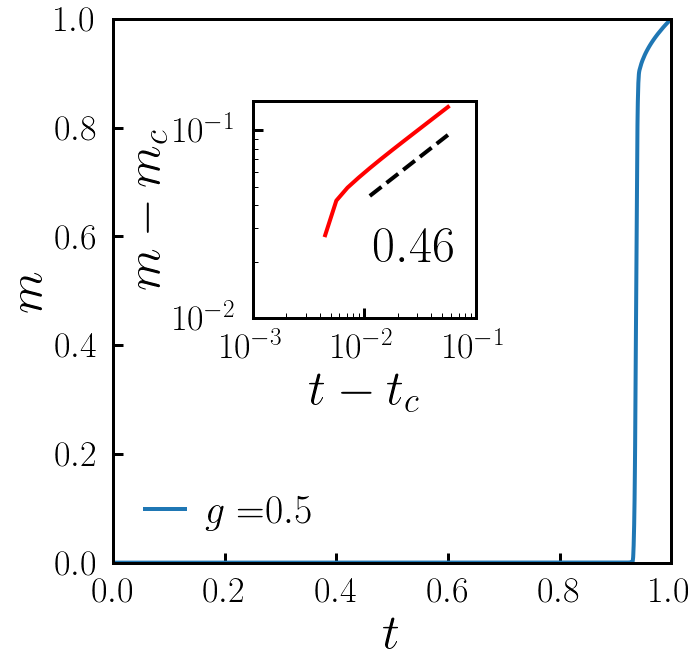

In [3]:
_, ax = plt.subplots()

networkSize = 10000
acceptanceThreshold = 0.5

# plot default
ax.plot(time, orderParameter[networkSize, acceptanceThreshold], label=latexString("g=")+latexFloat(0.5,1))

# default setting
xtick = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ytick = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexFloat(xtick,1))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexFloat(ytick,1))
ax.set_xlim(xtick[0], xtick[-1])
ax.set_ylim(ytick[0], ytick[-1])
ax.legend(loc='lower left')
ax.set_xlabel(latexString("t"))
ax.set_ylabel(latexString("m"))

# inset data
reducedT = logBinOrderParameter[networkSize, acceptanceThreshold][0]
op = logBinOrderParameter[networkSize, acceptanceThreshold][1]
mask = op>=0
reducedT = reducedT[mask]
op = op[mask]

# inset plot
ax1 = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.25,0.45,1,1), bbox_transform=ax.transAxes, loc='lower left', borderpad=0.0)
ax1.plot(reducedT, op, color='red')

# inset log fitting
fitX, fitY, beta, residual = logFit(reducedT[4:], op[4:], offset=0.15)
ax1.plot(fitX, fitY, 'k--')
ax1.text(1.2e-2,2e-2, latexFloat(beta,2))

# inset setting
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(latexString("t-t_c"))
ax1.set_ylabel(latexString("m-m_c"))
xtick = [1e-3,1e-2,1e-1]
ytick = [1e-2,1e-1]
ax1.set_xticks(xtick)
ax1.set_xticklabels(list_latexSci(xtick))
ax1.set_yticks(ytick)
ax1.set_yticklabels(list_latexSci(ytick))
ax1.set_xlim([1e-3,1e-1])
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.append(np.arange(1,10,1), np.arange(10,100,10)))
minortick_y = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax1.xaxis.set_minor_locator(minortick_x)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.yaxis.set_minor_locator(minortick_y)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
# plt.savefig("test")
# plt.savefig("test.png")
plt.show()


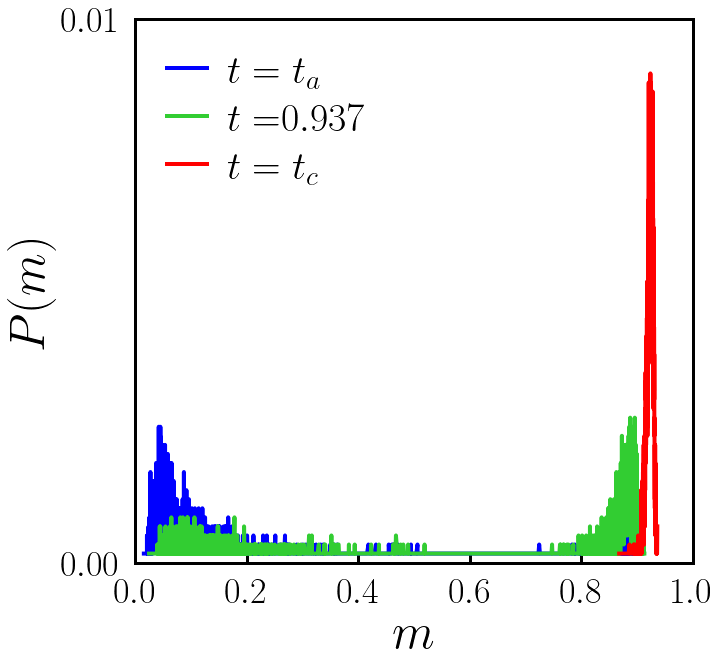

In [4]:
_, ax = plt.subplots()

networkSize = 10000
acceptanceThreshold = 0.5

# default plot
t = 0.932
op, distribution = orderParameterDistribution[networkSize, acceptanceThreshold, t]
ax.plot(op, distribution, color="blue", label=latexString("t=t_a"))

t = 0.937
op, distribution = orderParameterDistribution[networkSize, acceptanceThreshold, t]
ax.plot(op, distribution, color="limegreen", label=latexString("t=")+latexFloat(t))

t = 0.9482
op, distribution = orderParameterDistribution[networkSize, acceptanceThreshold, t]
ax.plot(op, distribution, color="red", label=latexString("t=t_c"))

# default setting
ax.legend(loc="upper left")
ax.set_xlabel(latexString("m"))
ax.set_ylabel(latexString("P(m)"))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 0.01])
xtick = np.linspace(0.0, 1.0, 6)
ytick = [0,0.01]
ax.set_xticks(xtick)
ax.set_yticks(ytick)
ax.set_xticklabels(list_latexFloat(xtick,1))
ax.set_yticklabels(list_latexFloat(ytick,2))

# save and show
plt.show()

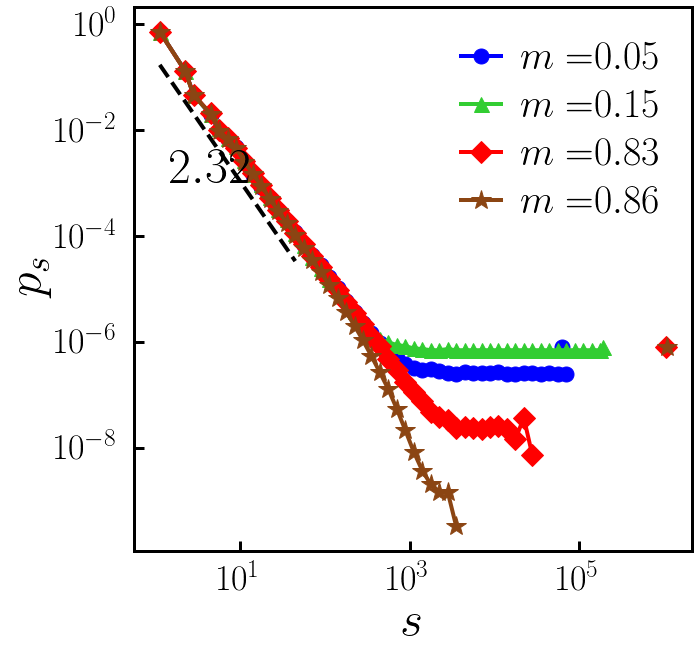

In [14]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# default plot
# op = 0.01
# clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
# ax.plot(clusterSize, dist, marker='v', color='darkturquoise', label=latexString("m=")+latexFloat(op,2))
# ax.plot(op*networkSize, 1/networkSize, marker='v', color='darkturquoise')

op = 0.05
clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
ax.plot(clusterSize, dist, marker='o', color='blue', label=latexString("m=")+latexFloat(op,2))
ax.plot(op*networkSize, 1/networkSize, marker='o', color='blue')

op = 0.15
clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
ax.plot(clusterSize, dist, marker='^', color='limegreen', label=latexString("m=")+latexFloat(op,2))
ax.plot(op*networkSize, 1/networkSize, marker='^', color='limegreen')

# op = 0.8
# clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
# ax.plot(clusterSize, dist, marker='s', color='orange', label=latexString("m=")+latexFloat(op,2))
# ax.plot(op*networkSize, 1/networkSize, marker='s', color='orange')

op = 0.8254
clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
ax.plot(clusterSize, dist, marker='D', color='red', label=latexString("m=")+latexFloat(op,2))
ax.plot(op*networkSize, 1/networkSize, marker='D', color='red')

# log fit
fitX, fitY, tau, residual = logFit(clusterSize[0:14], dist[0:14], offset=0.5)
ax.plot(fitX, fitY, 'k--')
ax.text(1.5,1e-3, latexFloat(-1*tau,2), fontsize=50)

op = 0.86
clusterSize, dist = clusterSizeDistribution[networkSize, acceptanceThreshold, op]
ax.plot(clusterSize, dist, marker='*', markersize=20, color='saddlebrown', label=latexString("m=")+latexFloat(op,2))
ax.plot(op*networkSize, 1/networkSize, marker='*', markersize=20, color='saddlebrown')

# default setting
ax.set_xlabel(latexString("s"))
ax.set_ylabel(latexString("p_s"))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="upper right")
# ax.set_xlim([1,1e4])
# ax.set_ylim([1e-6,1])
# xtick = [1e0, 1e1, 1e2, 1e3, 1e4]
# ytick = [1e-6, 1e-4, 1e-2, 1]
# ax.set_xticks(xtick)
# ax.set_yticks(ytick)
# ax.set_xticklabels(list_latexSci(xtick))
# ax.set_yticklabels(list_latexSci(ytick))
# minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.append(np.arange(1,10,1),np.arange(10,100,10)))
# ax.xaxis.set_minor_locator(minortick_x)
# ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
# ax.yaxis.set_minor_locator(minortick_y)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

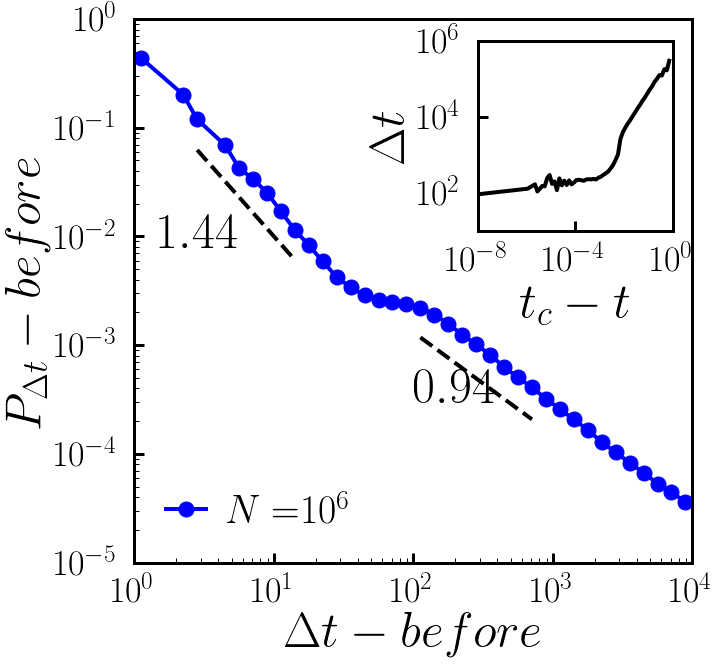

In [17]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
iet = interEventTimeDistribution_before[networkSize, acceptanceThreshold][0]
dist = interEventTimeDistribution_before[networkSize, acceptanceThreshold][1]
ax.plot(iet, dist, 'o-', color='blue', label=latexString("N=")+latexSci(networkSize))

# log fit
fitX, fitY, alpha, residual = logFit(iet[2:9], dist[2:9], offset=0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(1.5, 8e-3, latexFloat(-1*alpha,2), fontsize=50)
fitX, fitY, alpha, residual = logFit(iet[17:26], dist[17:26], offset=0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(1e2, 3e-4, latexFloat(-1*alpha,2), fontsize=50)

# main setting
ax.legend(loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta t-before"))
ax.set_ylabel(latexString("P_{\Delta t}-before"))
ax.set_xlim([1e0,1e4])
ax.set_ylim([1e-5,1e0])
xtick = np.power(10.0, np.linspace(0,4,5))
ytick = np.power(10.0, np.linspace(-5,0,6))
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.append(np.arange(1,10,1),np.arange(10,100,10)))
ax.xaxis.set_minor_locator(minortick_x)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax.yaxis.set_minor_locator(minortick_y)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# inset plot
ax1 = inset_axes(ax, width="35%", height="35%", loc='lower left', bbox_to_anchor=(0.615, 0.61, 1, 1), bbox_transform=ax.transAxes, borderpad=0.0)
reducedT = interEventTime[networkSize, acceptanceThreshold][0]
iet = interEventTime[networkSize, acceptanceThreshold][1]
ax1.plot(reducedT, iet, 'k-')

# inset setting
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(latexString("t_c-t"))
ax1.set_ylabel(latexString("\Delta t"))
ax1.set_xlim([1e-8,1e0])
ax1.set_ylim([1e1,1e6])
xtick = [1e-8,1e-4,1e0]
ytick = [1e2,1e4,1e6]
ax1.set_xticks(xtick)
ax1.set_xticklabels(list_latexSci(xtick))
ax1.set_yticks(ytick)
ax1.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e4, subs=np.arange(1000,10000,1000))
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax1.xaxis.set_minor_locator(minortick_x)
ax1.yaxis.set_minor_locator(minortick_y)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()


In [27]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
iet = interEventTimeDistribution_during[networkSize, acceptanceThreshold][0]
dist = interEventTimeDistribution_during[networkSize, acceptanceThreshold][1]
ax.plot(iet, dist, 'o-', color='blue', label=latexString("N=")+latexSci(networkSize))

# log fit
fitX, fitY, alpha, residual = logFit(iet[5:15], dist[5:15], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(2e1, 1e-3, latexFloat(alpha,2), fontsize=50)

# main setting
ax.legend(loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta t-during"))
ax.set_ylabel(latexString("P_{\Delta t-during}"))
ax.set_xlim([1e0,1e3])
ax.set_ylim([1e-7,1e0])
xtick = [1e0,1e1,1e2,1e3]
ytick = [1e-7,1e-5,1e-3,1e-1]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))

# save and show
plt.show()

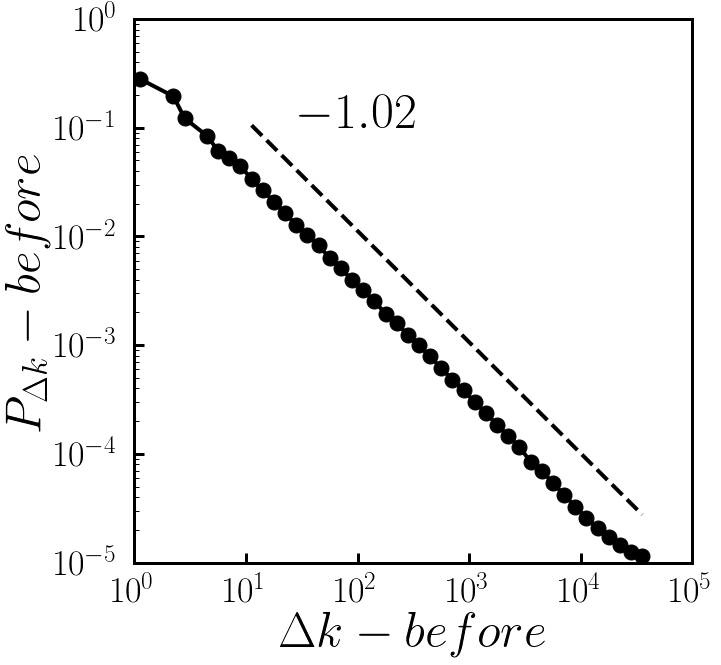

In [33]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
delK, dist = deltaUpperBoundDistribution_before[networkSize, acceptanceThreshold]
ax.plot(delK, dist, 'o-', color='black')

# log fit
fitX, fitY, alpha, residual = logFit(delK[7:], dist[7:], offset=-0.5)
ax.plot(fitX, fitY, 'k--')
ax.text(3e1, 1e-1, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta k-before"))
ax.set_ylabel(latexString("P_{\Delta k}-before"))
ax.set_xlim([1e0, 1e5])
ax.set_ylim([1e-5, 1e0])
xtick = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
ytick = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax.xaxis.set_minor_locator(minortick_x)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax.yaxis.set_minor_locator(minortick_y)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

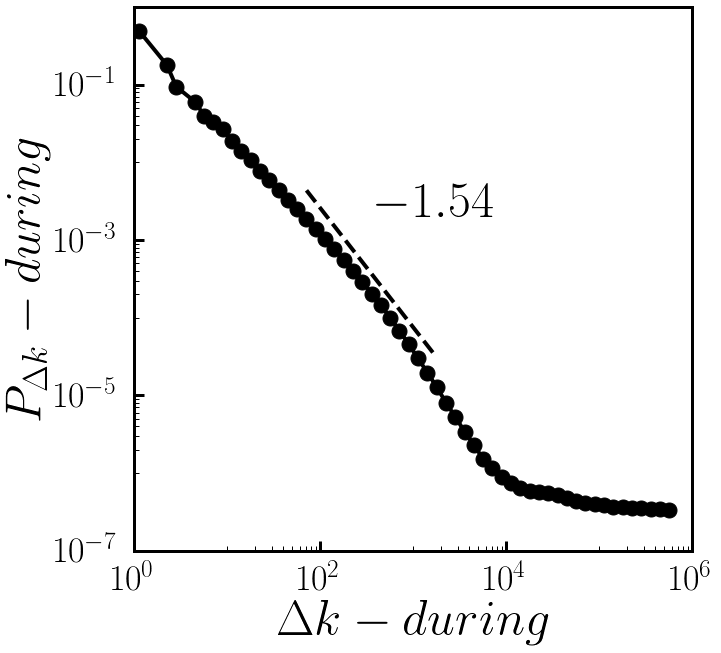

In [43]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
delK, dist = deltaUpperBoundDistribution_during[networkSize, acceptanceThreshold]
ax.plot(delK, dist, 'o-', color='black')

# log fit
fitX, fitY, alpha, residual = logFit(delK[15:30], dist[15:30], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(4e2, 2e-3, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta k-during"))
ax.set_ylabel(latexString("P_{\Delta k}-during"))
ax.set_xlim([1e0,1e6])
ax.set_ylim([1e-7,1e0])
xtick = [1e0,1e2,1e4,1e6]
ytick = [1e-7,1e-5,1e-3,1e-1]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.xaxis.set_minor_locator(minortick_x)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(1,10,1))
ax.yaxis.set_minor_locator(minortick_y)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

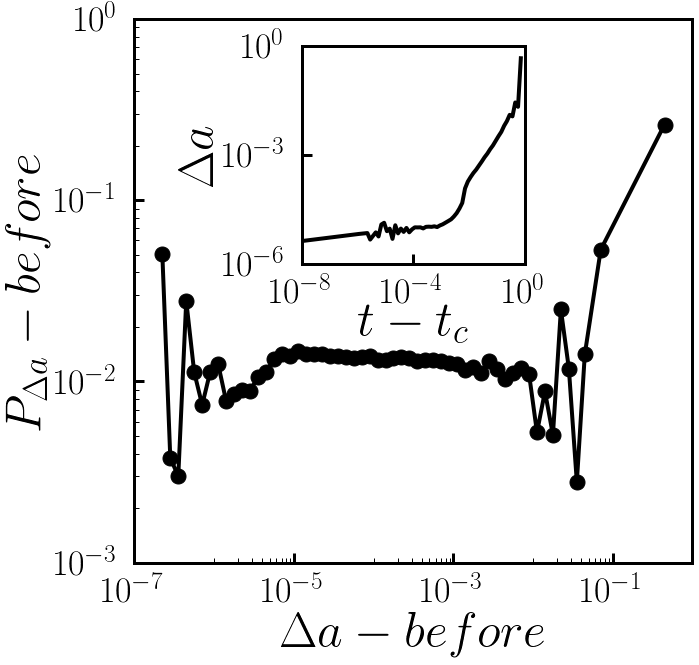

In [51]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
delA, dist = deltaAcceptanceDistribution_before[networkSize, acceptanceThreshold]
ax.plot(delA, dist, 'o-', color='black')

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta a-before"))
ax.set_ylabel(latexString("P_{\Delta a}-before"))
ax.set_xlim([1e-7, 1e0])
ax.set_ylim([1e-3, 1e0])
xtick = [1e-7, 1e-5, 1e-3, 1e-1]
ytick = [1e-3, 1e-2, 1e-1, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(1,10,1))
ax.xaxis.set_minor_locator(minortick_x)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax.yaxis.set_minor_locator(minortick_y)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# inset plot
ax1 = inset_axes(ax, width="40%", height="40%", loc='lower left', bbox_to_anchor=(0.3, 0.55, 1, 1), bbox_transform=ax.transAxes, borderpad=0.0)
reducedT = deltaAcceptance[networkSize, acceptanceThreshold][0]
delA = deltaAcceptance[networkSize, acceptanceThreshold][1]
ax1.plot(reducedT, delA, 'k-')

# inset setting
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(latexString("t-t_c"), labelpad=-10)
ax1.set_ylabel(latexString("\Delta a"), labelpad=0)
ax1.set_xlim([1e-8,1e0])
ax1.set_ylim([1e-6,1e0])
xtick = [1e-8,1e-4,1e0]
ytick = [1e-6,1e-3,1e0]
ax1.set_xticks(xtick)
ax1.set_xticklabels(list_latexSci(xtick))
ax1.set_yticks(ytick)
ax1.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e4, subs=np.arange(1000,10000,1000))
ax1.xaxis.set_minor_locator(minortick_x)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e3, subs=np.arange(100,1000,100))
ax1.yaxis.set_minor_locator(minortick_y)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

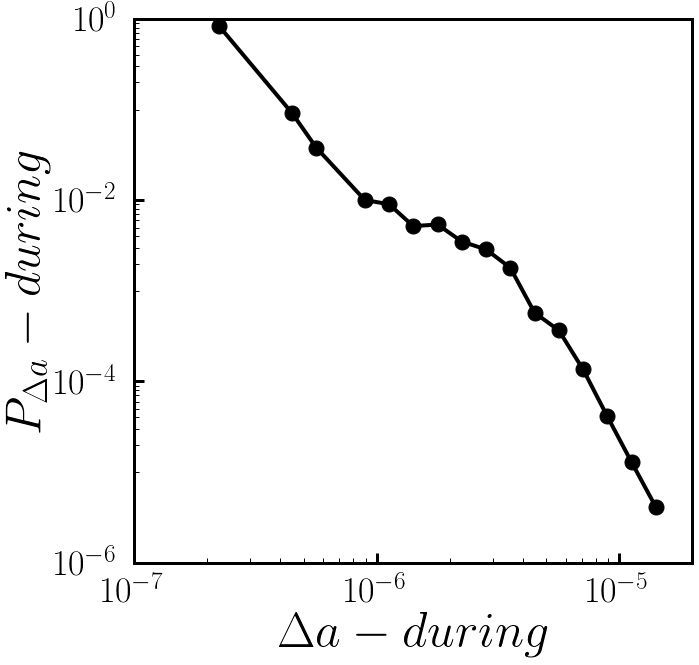

In [60]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
delA, dist = deltaAcceptanceDistribution_during[networkSize, acceptanceThreshold]
ax.plot(delA, dist, 'o-', color='black')

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta a-during"))
ax.set_ylabel(latexString("P_{\Delta a}-during"))
ax.set_xlim([1e-7, 2e-5])
ax.set_ylim([1e-6, 1e0])
xtick = [1e-7, 1e-6, 1e-5]
ytick = [1e-6, 1e-4, 1e-2, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e1, subs=np.arange(1,10,1))
ax.xaxis.set_minor_locator(minortick_x)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.yaxis.set_minor_locator(minortick_y)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

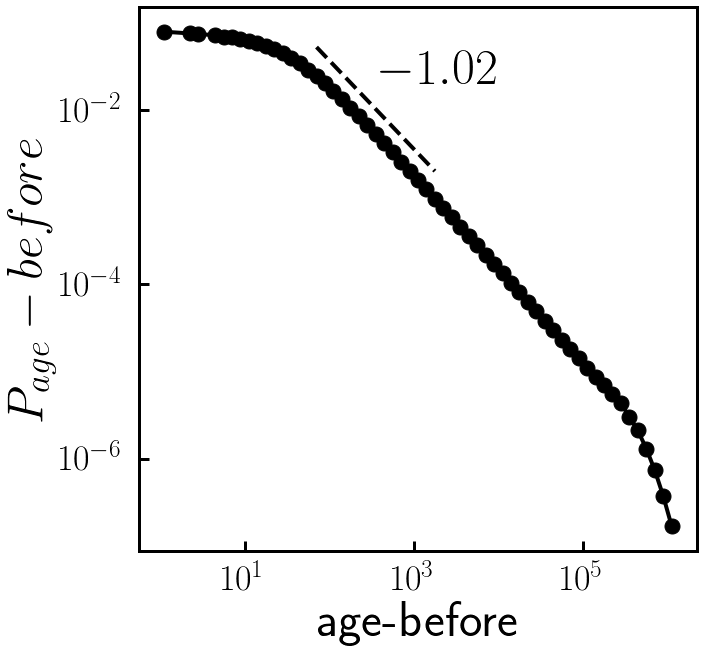

In [16]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
age, dist = ageDistribution_before[networkSize, acceptanceThreshold]
ax.plot(age, dist, 'ko-')

# log fit
fitX, fitY, alpha, residual = logFit(age[15:30], dist[15:30], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(4e2, 2e-2, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("age-before")
ax.set_ylabel(r"$P_{age}-before$")
# ax.set_xlim([1e0,1e4])
# ax.set_ylim([1e-5,1e-1])
# xtick = [1e0,1e2,1e4]
# ytick = [1e-5,1e-3,1e-1]
# ax.set_xticks(xtick)
# ax.set_xticklabels(list_latexSci(xtick))
# ax.set_yticks(ytick)
# ax.set_yticklabels(list_latexSci(ytick))
# minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
# minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(100,1000,100))
# ax.xaxis.set_minor_locator(minortick_x)
# ax.yaxis.set_minor_locator(minortick_y)
# ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()



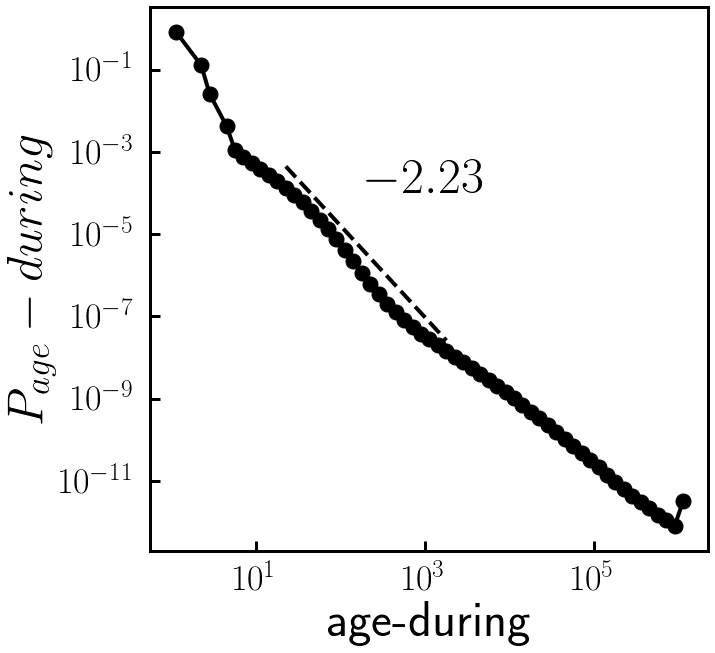

In [18]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
age, dist = ageDistribution_during[networkSize, acceptanceThreshold]
ax.plot(age, dist, 'ko-')

# log fit
fitX, fitY, alpha, residual = logFit(age[10:30], dist[10:30], offset=-0.5)
ax.plot(fitX, fitY, 'k--')
ax.text(2e2, 1e-4, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("age-during")
ax.set_ylabel(r"$P_{age}-during$")
# ax.set_xlim([1e0,1e4])
# ax.set_ylim([1e-8,1e0])
# xtick = [1e0,1e2,1e4]
# ytick = [1e-8,1e-6,1e-4,1e-2,1e0]
# ax.set_xticks(xtick)
# ax.set_xticklabels(list_latexSci(xtick))
# ax.set_yticks(ytick)
# ax.set_yticklabels(list_latexSci(ytick))
# minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
# minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
# ax.xaxis.set_minor_locator(minortick_x)
# ax.yaxis.set_minor_locator(minortick_y)
# ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()



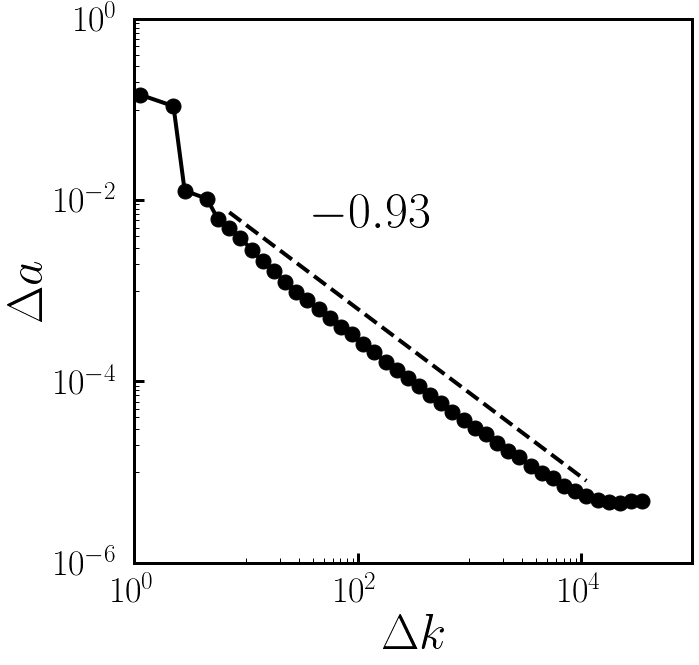

In [68]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
delK, delA = deltaUpperBound_DeltaAcceptance[networkSize, acceptanceThreshold]
ax.plot(delK, delA, 'ko-')

# log fit
fitX, fitY, alpha, residual = logFit(delK[5:-5], delA[5:-5], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(4e1, 5e-3, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta k"))
ax.set_ylabel(latexString("\Delta a"))
ax.set_xlim([1e0,1e5])
ax.set_ylim([1e-6,1e0])
xtick = [1e0, 1e2, 1e4]
ytick = [1e-6, 1e-4, 1e-2, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.xaxis.set_minor_locator(minortick_x)
ax.yaxis.set_minor_locator(minortick_y)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

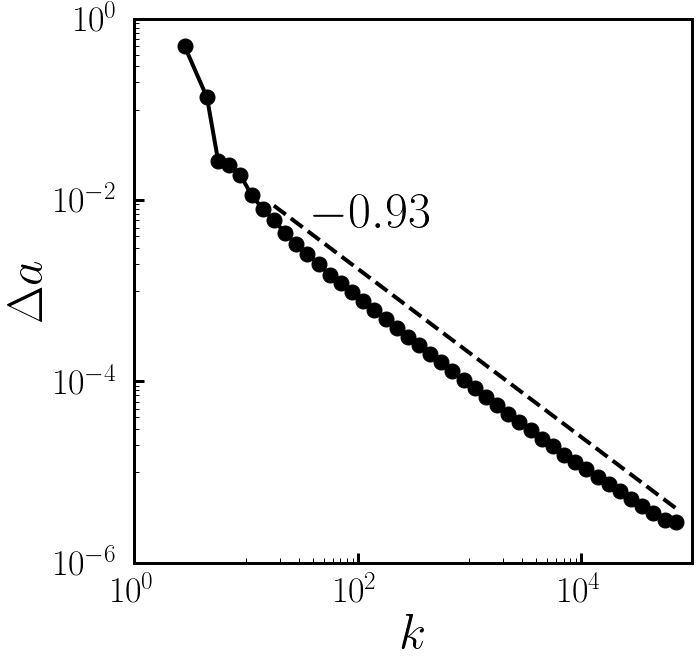

In [71]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
k, delA = upperBound_DeltaAcceptance[networkSize, acceptanceThreshold]
ax.plot(k, delA, 'ko-')

# log fit
fitX, fitY, alpha, residual = logFit(k[7:], delA[7:], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(4e1, 5e-3, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("k"))
ax.set_ylabel(latexString("\Delta a"))
ax.set_xlim([1e0,1e5])
ax.set_ylim([1e-6,1e0])
xtick = [1e0, 1e2, 1e4]
ytick = [1e-6, 1e-4, 1e-2, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.xaxis.set_minor_locator(minortick_x)
ax.yaxis.set_minor_locator(minortick_y)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

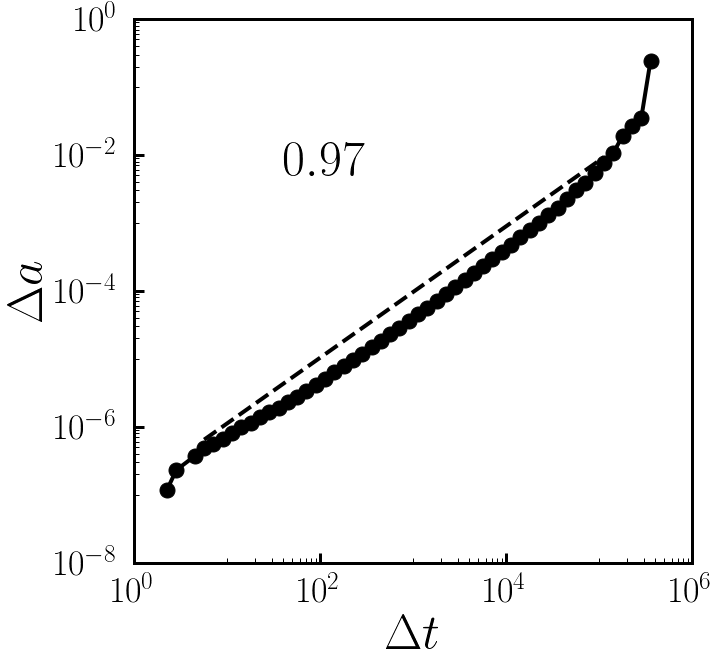

In [75]:
_, ax = plt.subplots(figsize=(10,10))

networkSize = 1280000
acceptanceThreshold = 0.5

# main plot
iet, delA = interEventTime_DeltaAcceptance[networkSize, acceptanceThreshold]
ax.plot(iet, delA, 'ko-')

# log fit
fitX, fitY, alpha, residual = logFit(iet[3:-5], delA[3:-5], offset=-0.3)
ax.plot(fitX, fitY, 'k--')
ax.text(4e1, 5e-3, latexFloat(alpha,2), fontsize=50)

# main setting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latexString("\Delta t"))
ax.set_ylabel(latexString("\Delta a"))
ax.set_xlim([1e0, 1e6])
ax.set_ylim([1e-8, 1e0])
xtick = [1e0, 1e2, 1e4, 1e6]
ytick = [1e-8, 1e-6, 1e-4, 1e-2, 1e0]
ax.set_xticks(xtick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticks(ytick)
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.xaxis.set_minor_locator(minortick_x)
ax.yaxis.set_minor_locator(minortick_y)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

# Dynamics

In [23]:
networkSize = 10000
acceptanceThreshold = 0.5

t, U, PL, PU, M, K, _ = dynamics_before[networkSize, acceptanceThreshold]

index = []
upperBound = []
i = 1
while len(index) < 7:
    if PL[i] == 1:
        index.append(i-1)
        upperBound.append(K[i-1])
    i += 1
# print(index)
# print(upperBound)

startIndex = index[2]-1
endIndex = index[-1]
A = t/U
PA = PL/PU
L = t/networkSize
l = L[startIndex:endIndex]
u = U[startIndex:endIndex]/networkSize
a = A[startIndex:endIndex]
k = K[startIndex:endIndex]



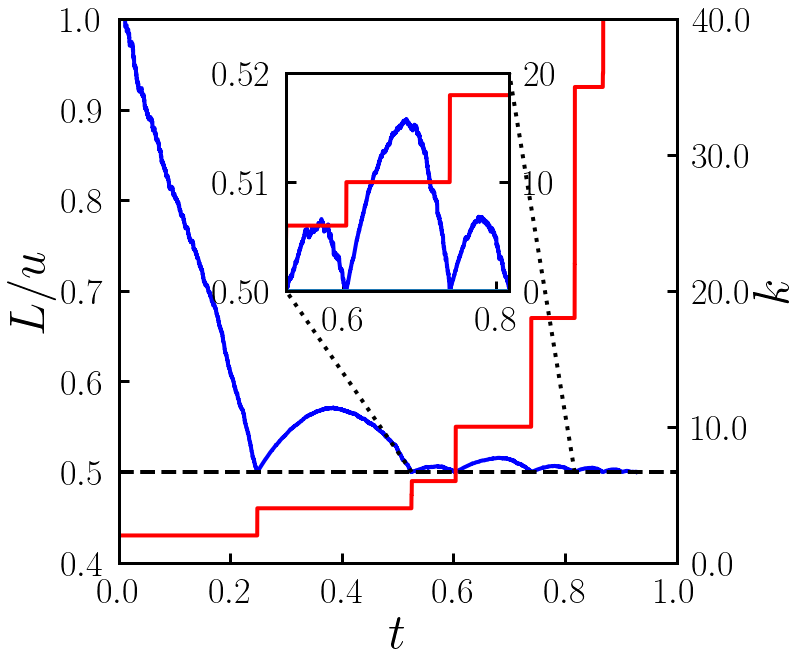

In [4]:
_, ax = plt.subplots()

inset_x = 0.3
inset_y = 0.5

# default plot
ax.plot(L, A, color='blue')
ax.plot([0,1], [acceptanceThreshold, acceptanceThreshold], 'k--')

# default setting
ax.set_xlabel(latexString("t"))
ax.set_ylabel(latexString("L/u"))
ax.set_xlim([0,1])
ax.set_ylim([acceptanceThreshold-0.1,1])
xtick = np.linspace(0, 1, 6)
ytick = np.linspace(0.4, 1, 7)
ax.set_xticks(xtick)
ax.set_yticks(ytick)
ax.set_xticklabels(list_latexFloat(xtick, 1))
ax.set_yticklabels(list_latexFloat(ytick, 1))

# zoom line
inset_x = 0.3
inset_y = 0.5
ax.plot([L[startIndex], inset_x], [0.5, (acceptanceThreshold+0.9)*inset_y], 'k:')
ax.plot([L[endIndex], inset_x+0.4], [0.5, (acceptanceThreshold+0.9)*inset_y+(1.1-acceptanceThreshold)*0.4], 'k:')

# twin plot
ax1 = ax.twinx()
ax1.plot(L, K, color='red')

# twin setting
ax1.set_ylabel(latexString("k"))
ax1.set_ylim([0,40])
ytick = np.linspace(0,40,5)
ax1.set_yticks(ytick)
ax1.set_yticklabels(list_latexFloat(ytick, 0))

# inset plot
ax2 = inset_axes(ax, width="40%", height="40%", loc='lower left', bbox_to_anchor=(inset_x, inset_y, 1, 1), bbox_transform=ax.transAxes, borderpad=0.0)
ax2.plot(l, a, color='blue')
ax2.plot([l[0], l[-1]], [acceptanceThreshold, acceptanceThreshold])

# inset settting
ax2.set_xlim([l[0], l[-1]])
ax2.set_ylim([acceptanceThreshold, acceptanceThreshold+0.02])
xtick = [0.6,0.8]
ytick = [0.5,0.51,0.52]
ax2.set_xticks(xtick)
ax2.set_yticks(ytick)
ax2.set_xticklabels(list_latexFloat(xtick, 1))
ax2.set_yticklabels(list_latexFloat(ytick, 2))

# inset twin plot
ax3 = ax2.twinx()
ax3.plot(l, k, color='red')

# inset twin setting
ytick = [0,10,20]
ax3.set_yticks(ytick)
ax3.set_yticklabels(list_latexFloat(ytick, 0))

# save and show
plt.show()

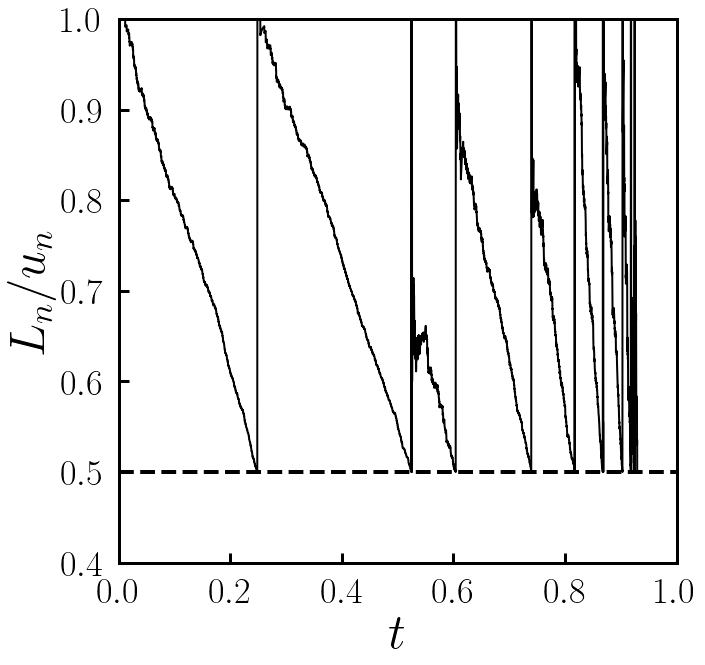

In [24]:
_, ax = plt.subplots()

# main plot
ax.plot(L, PA, color='black', linewidth=2)
ax.plot([0,1],[acceptanceThreshold,acceptanceThreshold], 'k--')

# main setting
ax.set_xlim([0,1])
ax.set_ylim([acceptanceThreshold-0.1,1])
ax.set_xlabel(latexString("t"))
ax.set_ylabel(latexString("L_n/u_n"))

# save and show
plt.show()

In [25]:
sampleNum = len(L)
sampligFrequency = 1.0/networkSize

fft_PA = fft(PA) / sampleNum
fft_PA = 2.0*np.abs(fft_PA[0:sampleNum//2])
frequency = np.linspace(0.0, 1.0/(2.0*sampligFrequency), sampleNum//2)
power = np.power(fft_PA, 2)

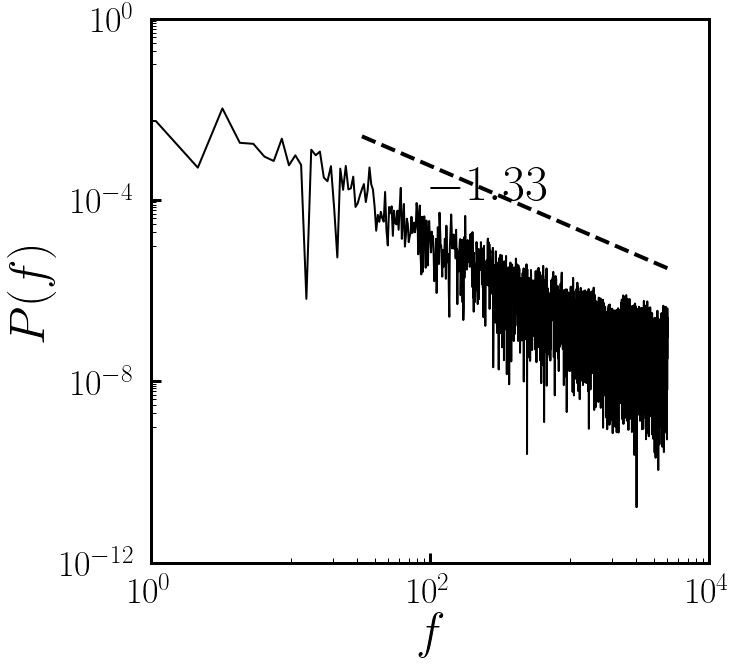

In [27]:
_, ax = plt.subplots()

# main plot
ax.plot(frequency, power, color='black', linewidth=2)

# log fit
fitX, fitY, alpha, residual = logFit(frequency[30:], power[30:], offset=-2)
ax.plot(fitX, fitY, 'k--')
ax.text(1e2, 1e-4, latexFloat(alpha,2))

# main setting
ax.set_xlabel(latexString("f"))
ax.set_ylabel(latexString("P(f)"))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e0,1e4])
ax.set_ylim([1e-12,1e0])
xtick = [1e0,1e2,1e4]
ytick = [1e-12,1e-8,1e-4,1e0]
ax.set_xticks(xtick)
ax.set_yticks(ytick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticklabels(list_latexSci(ytick))

minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
minortick_y = matplotlib.ticker.LogLocator(base=1e4, subs=np.arange(1000,10000,1000))
ax.xaxis.set_minor_locator(minortick_x)
ax.yaxis.set_minor_locator(minortick_y)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()

In [8]:
networkSize = 10000
acceptanceThreshold = 0.5

t, U, PL, PU, M, K, _ = dynamics_during[networkSize, acceptanceThreshold]

A = t/U
PA = PL/PU
L = t/networkSize


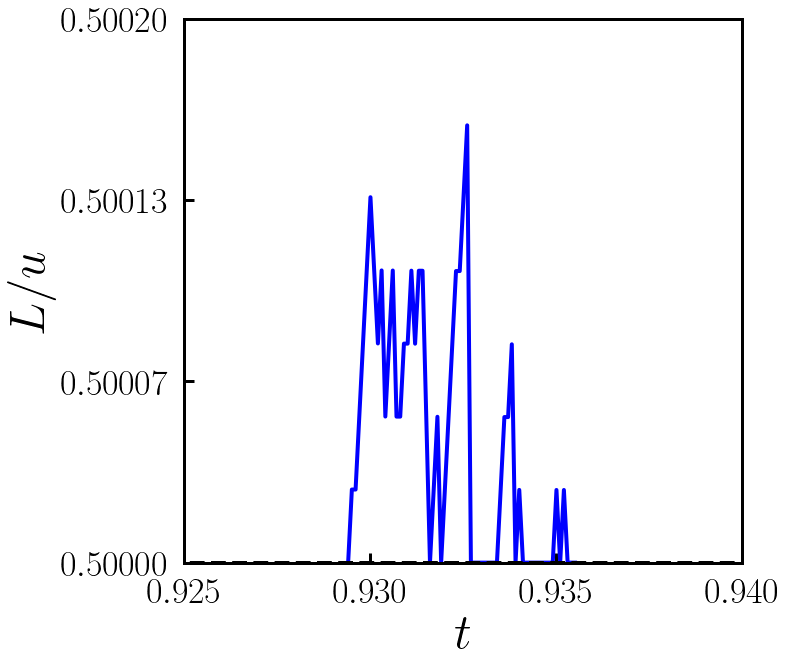

In [9]:
_, ax = plt.subplots()

# default plot
ax.plot(L, A, color='blue')
ax.plot([0,1], [acceptanceThreshold, acceptanceThreshold], 'k--')

# default setting
ax.set_xlabel(latexString("t"))
ax.set_ylabel(latexString("L/u"))
ax.set_xlim([0.925,0.94])
ax.set_ylim([acceptanceThreshold, acceptanceThreshold+0.0002])
xtick = np.linspace(0.925, 0.940, 4)
ytick = np.linspace(acceptanceThreshold, acceptanceThreshold+0.0002, 4)
ax.set_xticks(xtick)
ax.set_yticks(ytick)
ax.set_xticklabels(list_latexFloat(xtick, 3))
ax.set_yticklabels(list_latexFloat(ytick, 5))

# save and show
plt.show()

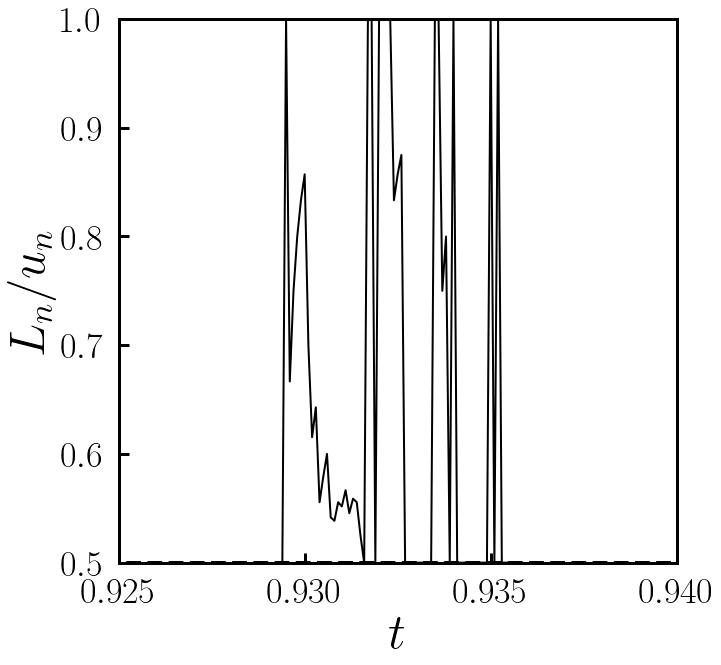

In [10]:
_, ax = plt.subplots()

# main plot
ax.plot(L, PA, color='black', linewidth=2)
ax.plot([0,1],[acceptanceThreshold,acceptanceThreshold], 'k--')

# main setting
ax.set_xlim([0.925,0.94])
ax.set_ylim([acceptanceThreshold,1])
ax.set_xlabel(latexString("t"))
ax.set_ylabel(latexString("L_n/u_n"))

# save and show
plt.show()

In [13]:
sampleNum = len(L)
sampligFrequency = 1.0/networkSize

fft_PA = fft(PA) / sampleNum
fft_PA = 2.0*np.abs(fft_PA[0:sampleNum//2])
frequency = np.linspace(0.0, 1.0/(2.0*sampligFrequency), sampleNum//2)
power = np.power(fft_PA, 2)

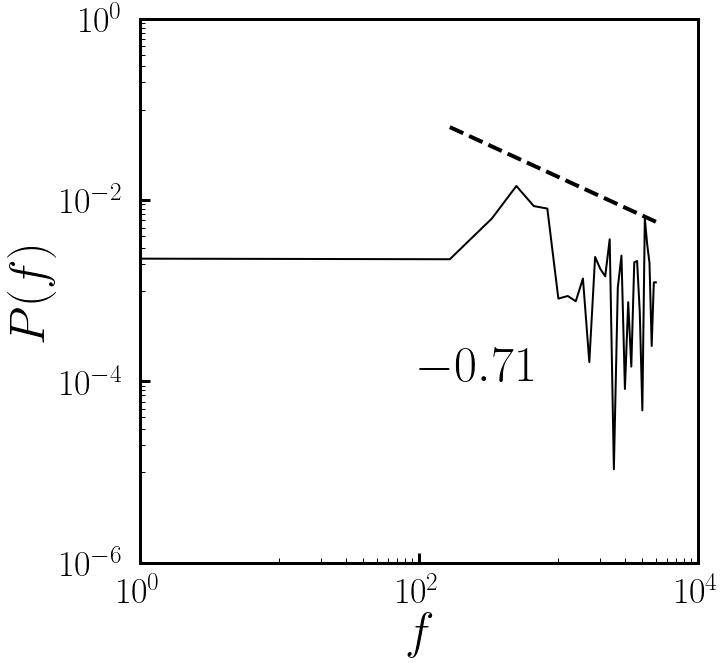

In [22]:
_, ax = plt.subplots()

# main plot
ax.plot(frequency, power, color='black', linewidth=2)

# log fit
fitX, fitY, alpha, residual = logFit(frequency[1:], power[1:], offset=-1)
ax.plot(fitX, fitY, 'k--')
ax.text(1e2, 1e-4, latexFloat(alpha,2))

# main setting
ax.set_xlabel(latexString("f"))
ax.set_ylabel(latexString("P(f)"))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e0,1e4])
ax.set_ylim([1e-6,1e0])
xtick = [1e0,1e2,1e4]
ytick = [1e-6, 1e-4, 1e-2, 1e0]
ax.set_xticks(xtick)
ax.set_yticks(ytick)
ax.set_xticklabels(list_latexSci(xtick))
ax.set_yticklabels(list_latexSci(ytick))
minortick_x = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
minortick_y = matplotlib.ticker.LogLocator(base=1e2, subs=np.arange(10,100,10))
ax.xaxis.set_minor_locator(minortick_x)
ax.yaxis.set_minor_locator(minortick_y)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save and show
plt.show()